### pre processing


In [1]:
import numpy as np
import librosa
import librosa.display
import os
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import random



In [2]:
train_dir = './data/train/audio/' #download files from kaggle

classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']

run this cell to move the background noises folder out of the audio directory. We will create silence samples from these files after.

In [ ]:
%%bash
mv data/train/audio/_background_noise_ data/train
ls data/train

Split all the audio files from \_background\_noises\_ folder in 1-sec chunks

In [ ]:
def split_arr(arr):
    """
    split an array into chunks of length 16000
    Returns:
        list of arrays
    """
    return np.split(arr, np.arange(16000, len(arr), 16000))

In [ ]:
def create_silence():
    """
    reads wav files in background noises folder, 
    splits them and saves to silence folder in train_dir
    """
    for file in os.listdir('data/train/_background_noise_/'):
        if 'wav' in file:
            sig, rate = librosa.load('data/train/_background_noise_/' + file, sr = 16000)        
            sig_arr = split_arr(sig)
            if not os.path.exists(train_dir+'silence/'):
                os.makedirs(train_dir+'silence/')
            for ind, arr in enumerate(sig_arr):
                filename = 'frag%d' %ind + '_%s' %file # example: frag0_running_tap.wav
                librosa.output.write_wav(train_dir+'silence/'+filename, arr, 16000)
  

In [ ]:
create_silence()

It is probably a good idea to make more silence samples yourself. 
Perhaps just by recording walking or driving around without speaking.
the silence class is underrepresented.

three lists with file names. one for training set, one for validation set, one for all. Plus a dictionary with file counts per class.

In [3]:
folders = os.listdir(train_dir)
# put folders in same order as in the classes list, used when making sets
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(folders):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'house', 'nine', 'four', 'happy', 'wow', 'five', 'zero', 'tree', 'six', 'one', 'three', 'eight', 'cat', 'two', 'seven', 'marvin', 'dog', 'sheila', 'bed', 'bird']


In [4]:
with open('./data/train/validation_list.txt') as val_list:
    validation_list = [row[0] for row in csv.reader(val_list)]
assert len(validation_list) == 6798, 'file not loaded'

"""
#if you want to add the files in testing_list.txt to the validation list:

with open('./data/train/testing_list.txt') as test_list:
    testing_list = [row[0] for row in csv.reader(test_list)]
assert len(testing_list) == 6835, 'file not loaded'

#combine into validation set
validation_list.extend(testing_list)
"""
#add silence files to validation_list
for i, file in enumerate(os.listdir(train_dir + 'silence/')):
    if i%10==0:
        validation_list.append('silence/'+file)

training_list = []
all_files_list = []
class_counts = {}

for folder in folders:
    files = os.listdir(train_dir + folder)
    for i, f in enumerate(files):
        all_files_list.append(folder + '/' + f)
        path = folder + '/' + f
        if path not in validation_list:
            training_list.append(folder + '/' + f)        
        class_counts[folder] = i

#remove filenames from validation_list that don't exist anymore (due to eda)
validation_list = list(set(validation_list).intersection(all_files_list))

In [5]:
assert len(validation_list)+len(training_list)==len(all_files_list), 'error'

In [6]:
# check random file name
print(training_list[345], 'size training set: ',len(training_list), 'size validation set: ', len(validation_list))

yes/15f04ff8_nohash_0.wav size training set:  58284 size validation set:  6839


In [7]:
print(class_counts)

{'tree': 1732, 'sheila': 1733, 'bird': 1730, 'no': 2374, 'four': 2371, 'zero': 2375, 'up': 2374, 'five': 2356, 'cat': 1732, 'yes': 2376, 'eight': 2351, 'off': 2356, 'seven': 2376, 'house': 1749, 'happy': 1741, 'three': 2355, 'left': 2352, 'two': 2372, 'bed': 1712, 'nine': 2363, 'dog': 1745, 'down': 2358, 'wow': 1744, 'right': 2366, 'on': 2366, 'one': 2369, 'go': 2371, 'marvin': 1745, 'stop': 2379, 'six': 2368, 'silence': 401}


plot a wav file

min:  -0.1182251 
max:  0.10827637 
mean:  7.842428e-06 
median:  0.0 
variance:  0.0003236237 
length:  10923


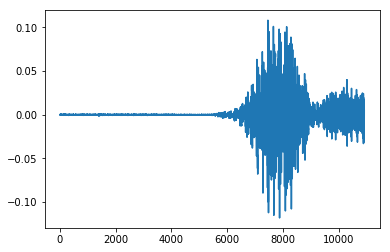

In [8]:
x, r = librosa.load(train_dir + 'yes/bfdb9801_nohash_0.wav', sr = 16000)
print('min: ',np.min(x), 
      '\nmax: ', np.max(x), 
      '\nmean: ', np.mean(x),
      '\nmedian: ', np.median(x),
      '\nvariance: ', np.var(x),
      '\nlength: ', len(x))
plt.plot(x)

### turn all wav files into spectrograms

In [9]:
def make_spec(file, file_dir = train_dir, flip = False, ps = False, st = 4):
    """
    create a melspectrogram from the amplitude of the sound
    
    Args:
        file (str): filename
        file_dir (str): directory path
        flip (bool): reverse time axis
        ps (bool): pitch shift
        st (int): half-note steps for pitch shift
    Returns:
        np.array with shape (122,85) (time, freq)
    """
    sig, rate = librosa.load(file_dir + file, sr = 16000)
    if len(sig) < 16000: # pad shorter than 1 sec audio with ramp to zero
        sig = np.pad(sig, (0,16000-len(sig)), 'linear_ramp')
    if ps:
        sig = librosa.effects.pitch_shift(sig, rate, st)
    D = librosa.amplitude_to_db(librosa.stft(sig[:16000], n_fft = 512, 
                                             hop_length = 128, 
                                             center = False), ref = np.max)
    S = librosa.feature.melspectrogram(S=D, n_mels = 85).T
    if flip:
        S = np.flipud(S)
    return S.astype(np.float32)

/home/chris/.conda/envs/deep/lib/python3.5/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


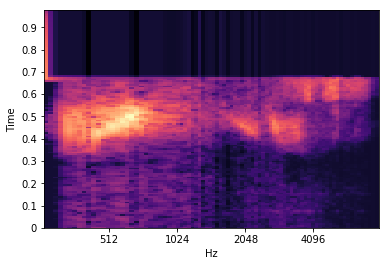

In [10]:
librosa.display.specshow(make_spec('yes/bfdb9801_nohash_0.wav'), 
                         x_axis='mel', 
                         fmax=8000, 
                         y_axis='time', 
                         sr = 16000,
                         hop_length = 128)

In [11]:
make_spec('yes/bfdb9801_nohash_0.wav').shape

(122, 85)

In [12]:
def create_sets(file_list = training_list):
    X_array = np.zeros([len(file_list),122,85])
    Y_array = np.zeros([len(file_list)])    
    for ind, file in enumerate(file_list):
        if ind%2000 == 0:
            print(ind, file)
        try:
            X_array[ind] = make_spec(file)
        except ValueError:
            print(ind, file, ValueError)
        Y_array[ind] = all_classes.index(file.rsplit('/')[0])
        
    return X_array, Y_array        
        

In [13]:
X_train, Y_train_all = create_sets() # takes a while

0 yes/8a28231e_nohash_3.wav
2000 yes/21307344_nohash_0.wav
4000 silence/frag55_dude_miaowing.wav
6000 nine/283d7a53_nohash_1.wav
8000 four/31d31fa0_nohash_0.wav
10000 wow/d84829e0_nohash_0.wav
12000 five/173e6bbf_nohash_0.wav
14000 stop/bbd0bbd0_nohash_4.wav
16000 off/29fb33da_nohash_0.wav
18000 zero/39543cfd_nohash_1.wav
20000 tree/6a203e0e_nohash_3.wav
22000 up/01b4757a_nohash_0.wav
24000 six/21cbe292_nohash_0.wav
26000 one/3b852f6f_nohash_0.wav
28000 down/b959cd0c_nohash_4.wav
30000 three/23abe1c9_nohash_1.wav
32000 three/f953e1af_nohash_1.wav
34000 right/75915c90_nohash_0.wav
36000 eight/85b877b5_nohash_0.wav
38000 no/88053e92_nohash_0.wav
40000 two/a1c63f25_nohash_0.wav
42000 two/c1d39ce8_nohash_8.wav
44000 seven/72ca6a6d_nohash_0.wav
46000 on/0137b3f4_nohash_3.wav
48000 left/1b4c9b89_nohash_4.wav
50000 dog/dfb6450b_nohash_0.wav
52000 go/0137b3f4_nohash_2.wav
54000 sheila/1ecfb537_nohash_0.wav
56000 bed/129c7d8d_nohash_0.wav
58000 bird/b9f46737_nohash_0.wav


In [15]:
# all unknown are index 11
Y_train = np.where(Y_train_all < 11, Y_train_all, 11)

In [21]:
print(len(Y_train) == len(Y_train_all), 12 in Y_train)

True False


In [22]:
X_train.shape

(58284, 122, 85)

In [23]:
Y_train_all.shape

(58284,)

In [24]:
Y_train.shape

(58284,)

/home/chris/.conda/envs/deep/lib/python3.5/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


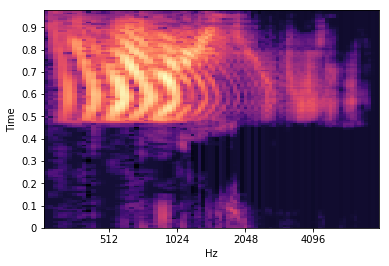

In [25]:
librosa.display.specshow(X_train[6500], 
                         x_axis='mel', 
                         fmax=8000, 
                         y_axis='time', 
                         sr = 16000,
                         hop_length = 128)

In [27]:
print('min: ',np.min(X_train), 
      '\nmax: ', np.max(X_train), 
      '\nmean: ', np.mean(X_train),
      '\nmedian: ', np.median(X_train),
      '\nvariance: ', np.var(X_train))

min:  -2.0306179523468018 
max:  9.682740653715882e-08 
mean:  -1.3092733940164247 
median:  -1.3604837656021118 
variance:  0.1966961502974185


(array([ 1228696.,   145193.,  3275026.,  7532802., 82702715., 22856648.,
        16916705., 16934789., 16204832., 16512872., 17009321., 17513298.,
        18006821., 18386293., 18671277., 18840052., 18900365., 18844455.,
        18653069., 18317537., 17824610., 17199633., 16469783., 15675113.,
        14854939., 14015966., 13175555., 12330033., 11511119., 10719554.,
         9957441.,  9224338.,  8533548.,  7891582.,  7293816.,  6750723.,
         6248039.,  5776133.,  5309989.,  4838909.,  4358126.,  3874961.,
         3362954.,  2819091.,  2260820.,  1739511.,  1302868.,   864668.,
          526419.,   242073.]),
 array([-2.03061795e+00, -1.99000559e+00, -1.94939323e+00, -1.90878087e+00,
        -1.86816851e+00, -1.82755615e+00, -1.78694379e+00, -1.74633143e+00,
        -1.70571906e+00, -1.66510670e+00, -1.62449434e+00, -1.58388198e+00,
        -1.54326962e+00, -1.50265726e+00, -1.46204490e+00, -1.42143254e+00,
        -1.38082018e+00, -1.34020782e+00, -1.29959545e+00, -1.25898309e+

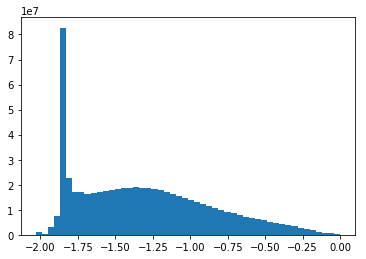

In [28]:
plt.hist(X_train.flatten(), bins = 50)

save the training sets, add channel dimension for keras,
normalize around zero

In [29]:
np.save('data/X_train.npy', np.expand_dims(X_train, -1)+1.3)
np.save('data/Y_train.npy', Y_train.astype(np.int))
np.save('data/Y_train_all.npy', Y_train_all.astype(np.int))

In [30]:
X_val, Y_val_all = create_sets(file_list = validation_list)

0 three/8910e5ef_nohash_0.wav
2000 off/c6ee87a7_nohash_4.wav
4000 up/d197e3ae_nohash_1.wav
6000 three/c2d15ea5_nohash_1.wav


In [31]:
Y_val = np.where(Y_val_all < 11, Y_val_all, 11)

(array([  154940.,    18034.,   411645.,   957655., 10308998.,  2858934.,
         2146572.,  2155738.,  2049890.,  2059567.,  2087878.,  2115111.,
         2131926.,  2143096.,  2147216.,  2145486.,  2141127.,  2122224.,
         2092951.,  2052708.,  2001016.,  1937831.,  1861559.,  1778916.,
         1684342.,  1583813.,  1480579.,  1375775.,  1280530.,  1183247.,
         1094346.,  1015542.,   940413.,   874785.,   811776.,   751289.,
          699219.,   648563.,   594666.,   546062.,   497429.,   447748.,
          394618.,   331298.,   265489.,   202657.,   148109.,    99220.,
           61790.,    26107.]),
 array([-2.03061795e+00, -1.99000559e+00, -1.94939323e+00, -1.90878087e+00,
        -1.86816851e+00, -1.82755615e+00, -1.78694379e+00, -1.74633143e+00,
        -1.70571906e+00, -1.66510670e+00, -1.62449434e+00, -1.58388198e+00,
        -1.54326962e+00, -1.50265726e+00, -1.46204490e+00, -1.42143254e+00,
        -1.38082018e+00, -1.34020782e+00, -1.29959546e+00, -1.25898309e+

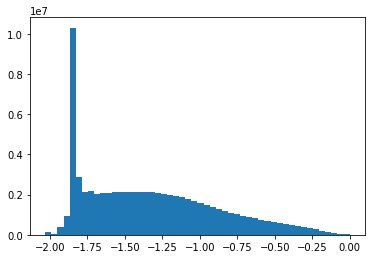

In [32]:
plt.hist(X_val.flatten(), bins = 50)

In [33]:
np.save('data/X_val.npy', np.expand_dims(X_val, -1)+1.3)
np.save('data/Y_val.npy', Y_val.astype(np.int))
np.save('data/Y_val_all.npy', Y_val_all.astype(np.int))